In [30]:
%load_ext autoreload
%autoreload 2

# First, import a few Python packages and landlab tools
import numpy as np
from pylab import show, figure, plot
import time
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from scipy import stats
from osgeo import gdal
import glob
from PIL import Image
import matplotlib.cbook as cbook
import scipy.optimize
from scipy.optimize import curve_fit
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
mpl.rcParams['font.size'] = 8
import utils
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load analysis outputs from csv file

In [31]:
# load data 
excel_filename = 'information_loss_analysis_outputs.csv'
data = pd.read_csv(excel_filename)

### Plot degradation coefficient and line length change over time

We define the degradation coefficient $\phi$ as:

\begin{equation}

\phi = \frac{{mod(slope_{t0})}}{{mod(slope_{t})}}

\end{equation}

0     289.920118
5     526.527820
10    507.719099
15    244.427059
20    472.076732
25    177.943744
30    218.916013
35    235.420485
40    167.402168
45    276.632121
50    526.477155
55    422.484212
60    144.125654
65    137.725443
70    473.992147
75    740.559255
80    289.630804
85    196.556392
90    449.041222
95    535.918944
Name: Length (m), dtype: float64
1     274.936987
6     458.635364
11    426.135695
16    235.892078
21    286.862522
26    168.397559
31    201.156333
36    212.423338
41    160.791616
46    192.507263
51    456.967597
56    360.230601
61    139.151799
66    133.507118
71    408.302029
76    642.465843
81    194.367043
86    170.548711
91    249.902981
96    473.518714
Name: Length (m), dtype: float64
2     253.625034
7     337.561192
12    268.856703
17    235.677415
22    216.759854
27    151.605835
32    179.766331
37    172.521562
42    141.861744
47    160.773795
52    252.204347
57    320.901425
62    116.518999
67    129.791000
72    307.488178

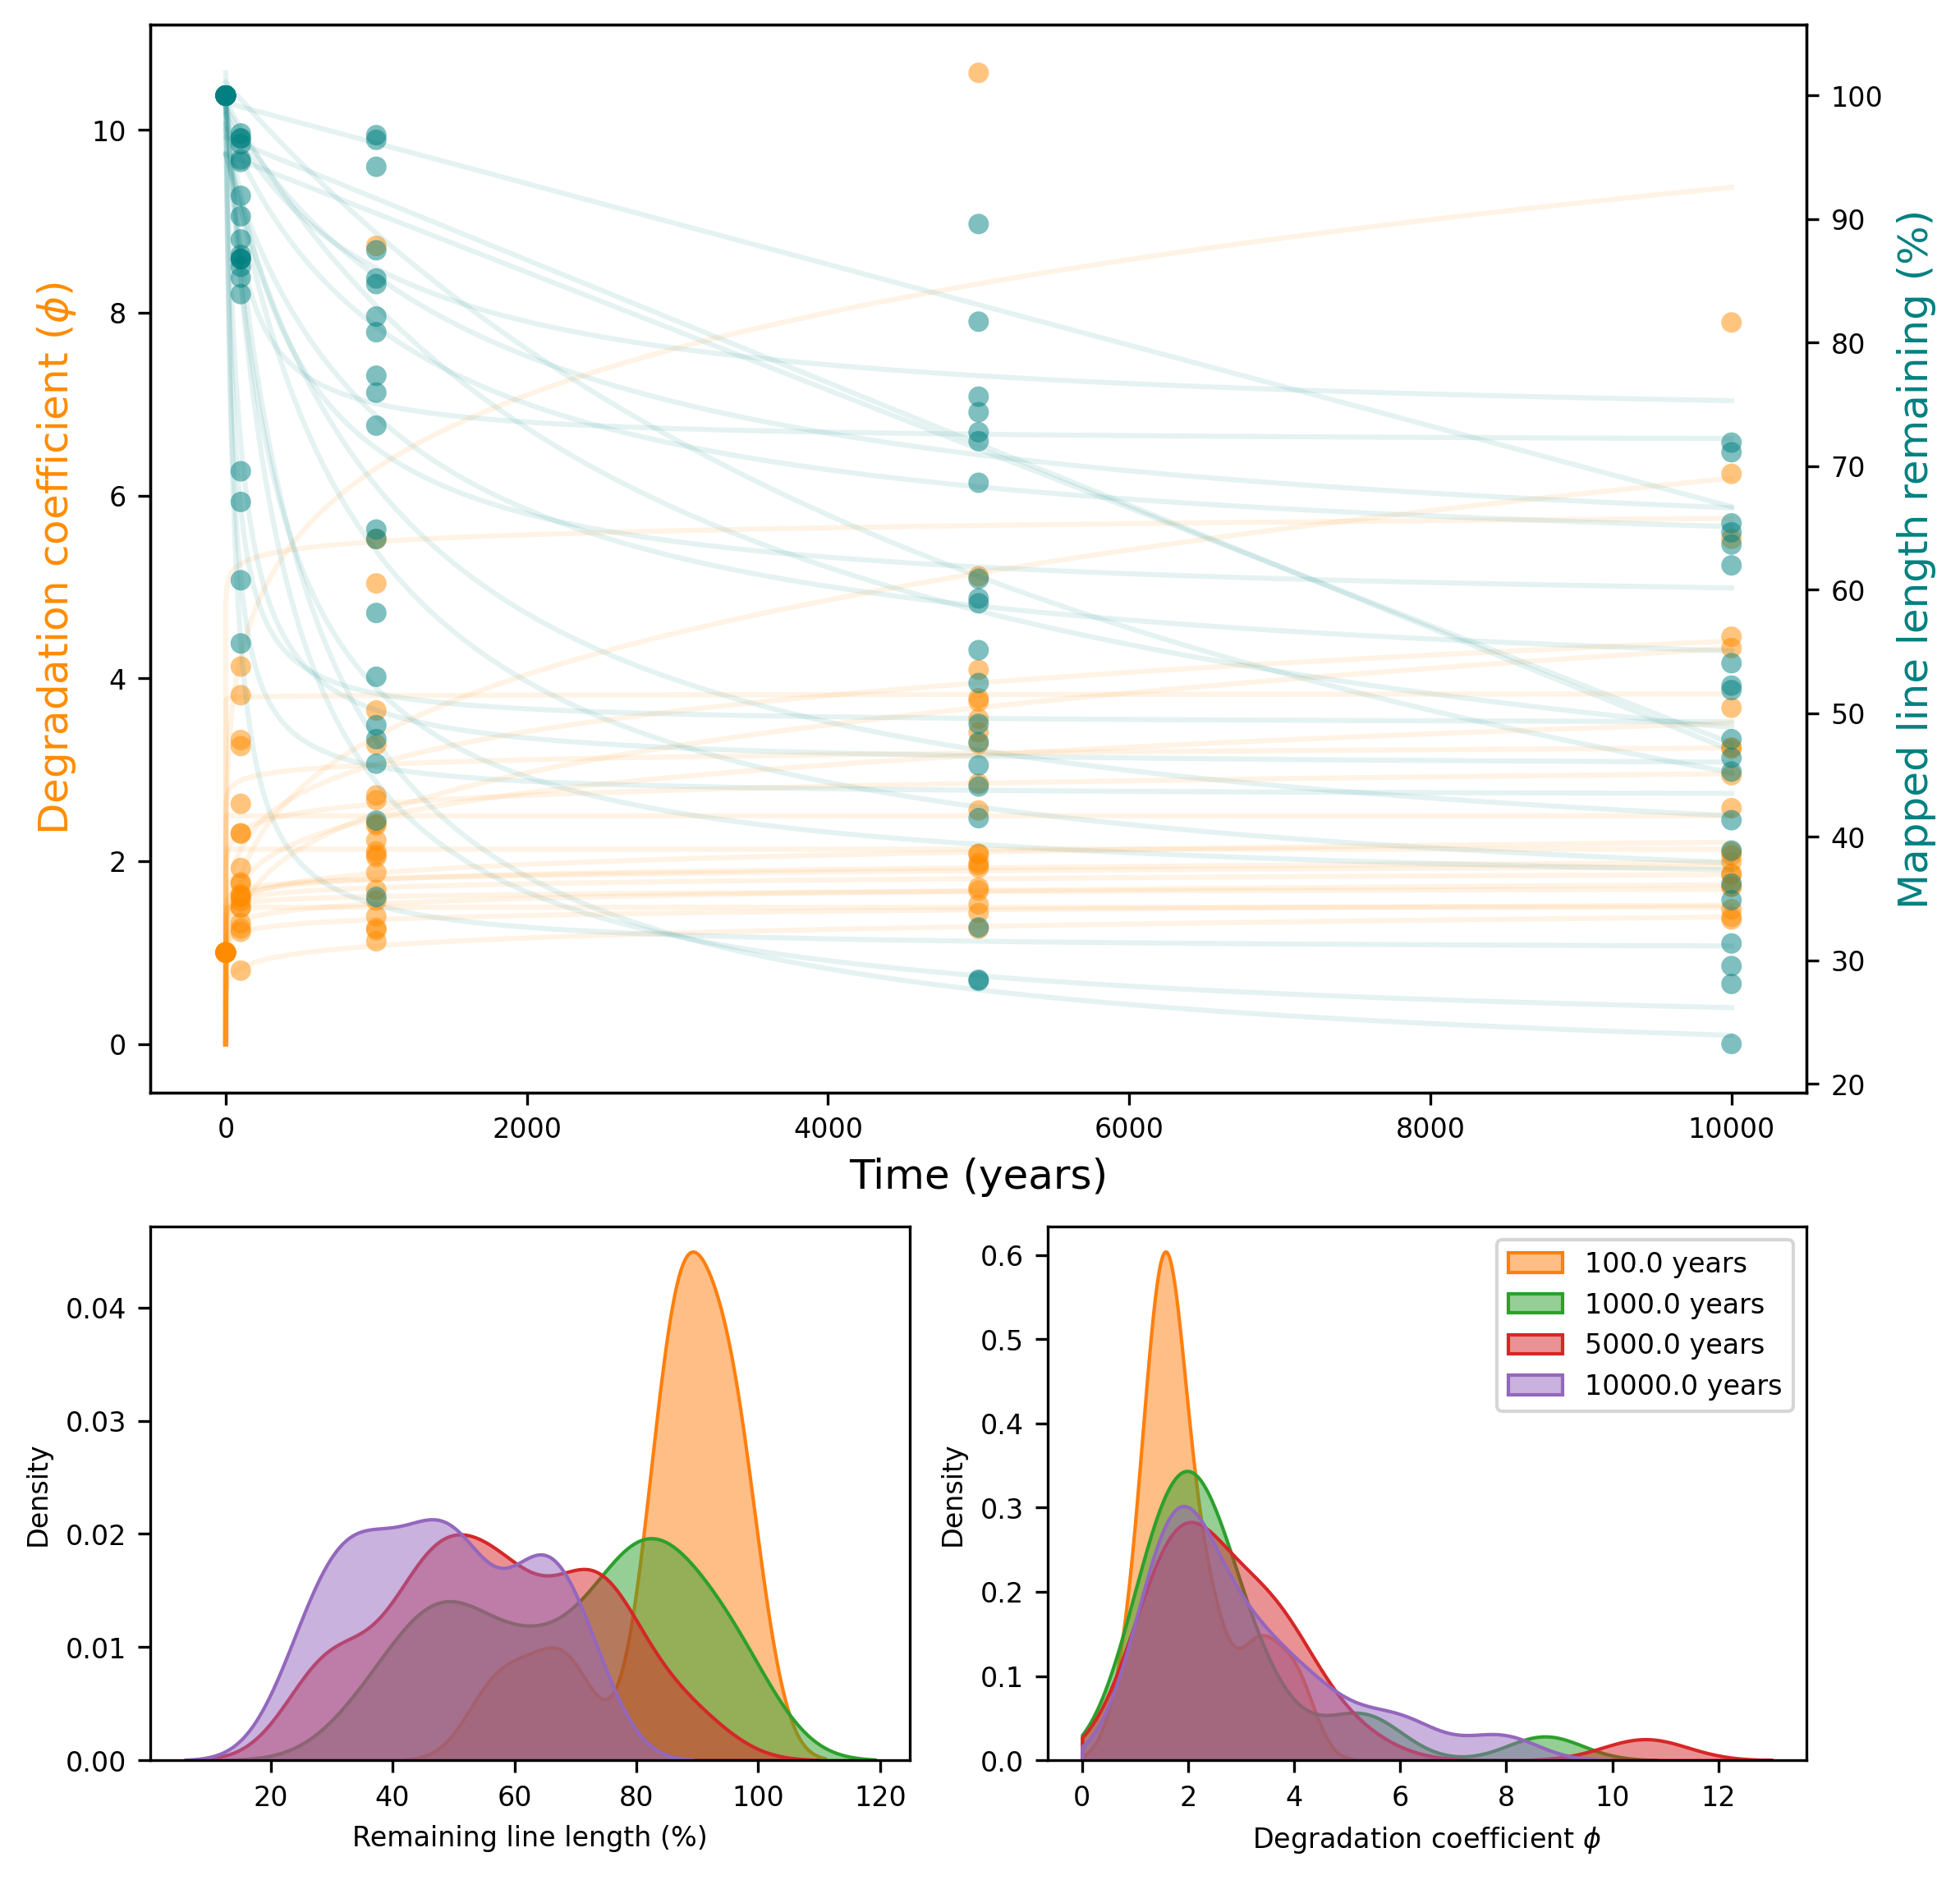

In [40]:
grouped = data.groupby('DEM ID')

# annoying figure set up but will look pretty
fig = plt.figure(figsize=(8, 10), dpi=300)
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
ax_big = fig.add_subplot(gs[0, :])
ax_small1 = fig.add_subplot(gs[1, 0])
ax_small2 = fig.add_subplot(gs[1, 1])


ax2 = ax_big.twinx()

# plot both degradation coefficient and % length remaining over time 
for name, group in grouped:
    ax_big.scatter(group['Time (years)'], group['Degradation coefficient'],c='darkorange',alpha=0.5,edgecolor='none')
    normalized_length = group['Length (m)'] / group['Length (m)'].iloc[0]
    ax2.scatter(group['Time (years)'], normalized_length*100, c='teal',alpha=0.5,edgecolor='none')  
    
    popt_deg, pcov_deg = curve_fit(utils.func_deg_coeff, group['Time (years)'], group['Degradation coefficient'])
    popt_line, pcov_line= curve_fit(utils.func_line_length, group['Time (years)'], normalized_length)

    x = np.linspace(min(group['Time (years)']),max(group['Time (years)']),10000)

    ax_big.plot(x,utils.func_deg_coeff(x, *popt_deg),color='darkorange',alpha=0.1)
    ax2.plot(x,utils.func_line_length(x, *popt_line)*100,color='teal',alpha=0.1)
    ax_big.set_ylabel('Degradation coefficient ($\phi$)',c='darkorange',fontsize=12)
    ax_big.set_xlabel('Time (years)',fontsize=12)
    ax2.set_ylabel('Mapped line length remaining (%)',c='teal',fontsize=12)

# saving normalized length 
length_at_time_zero = data[data['Time (years)'] == 0.0].set_index('DEM ID')['Length (m)'].to_dict()

def normalize_length(row):
    return row['Length (m)'] / length_at_time_zero[row['DEM ID']]

data['Normalized length'] = data.apply(normalize_length, axis=1)


# plot distribution of length remaining over time and degradation coefficient over time
grouped = data.groupby('Time (years)')
for key,group in grouped:
    print(group['Length (m)'])
    sns.kdeplot(group['Normalized length'] * 100, ax=ax_small1, label=f'{key} years', fill=True, alpha=0.5, clip=(1e-5, None),bw_adjust=0.7)
    sns.kdeplot(group['Degradation coefficient'], ax=ax_small2, label=f'{key} years', fill=True, alpha=0.5, clip=(1e-5, None),bw_adjust=0.7)

ax_small1.set_xlabel('Remaining line length (%)')
ax_small2.set_xlabel(f'Degradation coefficient $\phi$')
ax_small2.legend()

plt.tight_layout()